In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
import sys
import os
sys.path.append("..")

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from neuralbridge.run_scripts.read_config import read_config
from neuralbridge.stochastic_processes.examples import (
    CellDiffusionProcess, 
    CellDiffusionAuxProcess
)
from neuralbridge.solvers.sde import WienerProcess, Euler, SamplePath
from neuralbridge.stochastic_processes.conds import GuidedBridgeProcess
from neuralbridge.models import neurb, pCN, scorematching
from neuralbridge.utils.plotting import plot_sample_path, plot_mcmc_sample_path

### Conditioning on normal events

Neural bridge

In [4]:
config = read_config("../configs/cell_normal.yaml")
print(config)
u = jnp.array(config.sde.u)
v = jnp.array(config.sde.v)

W = WienerProcess(
    T=config.sde.T,
    dt=config.sde.dt,
    shape=(config.sde.dim, )
)

X = CellDiffusionProcess(
    params=config.sde.params_X,
    T=config.sde.T,
    dim=config.sde.dim
)
X_tilde = CellDiffusionAuxProcess(
    params=config.sde.params_X_tilde,
    T=config.sde.T,
    dim=config.sde.dim
)
X_circ = GuidedBridgeProcess(
    X=X,
    X_tilde=X_tilde,
    u=u,
    v=v,
    eps=config.sde.eps,
    ts=jnp.arange(0, config.sde.T + config.sde.dt, config.sde.dt),
)
X_diamond = neurb.NeuralBridge(
    X_circ=X_circ,
    config=config
)

X_diamond.initialize_solver(W)
_ = X_diamond.train(mode="pretrained", load_relative_dir="../assets/ckpts/neurb")
X_diamond_path = X_diamond.solve(x0=u, rng_key=jax.random.PRNGKey(42), batch_size=32)

/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1136: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(
INFO:root:Checkpoint loaded from /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neurb/cell_model_normal_events_sigma0.1
INFO:root:Loading pretrained model from the last epoch


{'sde': {'dim': 2, 'T': 4.0, 'dt': 0.01, 'params_X': {'alpha': 0.0625, 'sigma': 0.1}, 'params_X_tilde': {'alpha': 0.0625, 'sigma': 0.1}, 'u': [0.1, -0.1], 'v': [2.0, -0.1], 'eps': 1e-10}, 'network': {'mlp_type': 'mlp_small', 'out_dim': 2, 'hidden_dims': [20, 20, 20, 20], 'activation': 'tanh'}, 'training': {'save_name': 'cell_model_normal_events_sigma0.1', 'learning_rate': 0.0005, 'batch_size': 64, 'n_iters': 500, 'n_epochs': 10, 'ema_decay': 0.995, 'optimizer': 'adam', 'warmup_steps': 500, 'clip_norm': None}}


Score matching

In [6]:
config = read_config("../configs/cell_normal_score.yaml")
print(config)
score_model = scorematching.ScoreMatchingReversedBridge(
    X=X,
    u=u,
    v=v,
    config=config
)
_ = score_model.train(mode="pretrained", load_relative_dir="../assets/ckpts/score/")
Y_star = score_model.build_reversed_bridge()
Y_star_solver = Euler(sde=Y_star, W=W)
Y_star_path = Y_star_solver.solve(x0=v, rng_key=jax.random.PRNGKey(42), batch_size=32)
X_star_score_path = SamplePath(
    xs=Y_star_path.xs[:, ::-1, :],
    ts=Y_star_path.ts
)

{'sde': {'dim': 2, 'T': 4.0, 'dt': 0.01, 'params_X': {'alpha': 0.0625, 'sigma': 0.1}, 'u': [0.1, -0.1], 'v': [2.0, -0.1]}, 'network': {'mlp_type': 'mlp', 'out_dim': 2, 'hidden_dims': [32, 32, 32, 32], 't_emb_dim': 32, 't_emb_max_period': 100.0, 't_emb_scaling': 100.0, 'norm': 'batch', 'activation': 'tanh'}, 'training': {'save_name': 'cell_model_normal_events_sigma0.1', 'learning_rate': 0.0005, 'batch_size': 64, 'n_iters': 1000, 'n_epochs': 20, 'ema_decay': 0.995, 'optimizer': 'adam', 'warmup_steps': 1000, 'clip_norm': None}}


/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1136: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(
INFO:root:Checkpoint loaded from /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/score/cell_model_normal_events_sigma0.1
INFO:root:Loading pretrained model from the last epoch


Adjoint forward

In [10]:
config = read_config("../configs/cell_normal_adjoint.yaml")
print(config)

from flax.training import checkpoints
from legacies.adjoint_forward.models.score_mlp import ScoreMLP
from legacies.adjoint_forward.sdes import sde_cell_model, sde_utils
from legacies.adjoint_forward.training import train_utils
network = ScoreMLP(**config.network)
ckpt = checkpoints.restore_checkpoint(
    ckpt_dir=os.path.abspath("../assets/ckpts/adjoint/cell_model_normal_0.1sigma"),
    target=None,
    step=0,
    prefix="checkpoint_"
)
params = ckpt["params"]
batch_stats = ckpt["batch_stats"]
trained_score = train_utils.trained_score(network, params, batch_stats)

cell_sde = sde_cell_model.cell_model(
    T=config.sde.T, 
    N=int(config.sde.T / config.sde.dt), 
    alpha=config.sde.alpha, 
    sigma=config.sde.sigma
)
n_samples = 32
rng_keys = jax.random.split(jax.random.PRNGKey(42), n_samples)
xs_star = jax.vmap(
    sde_utils.conditioned,
    in_axes=(0, None, None, None)
)(rng_keys, u, cell_sde, trained_score)
ts = jnp.arange(0, config.sde.T, config.sde.dt)
X_star_adjoint_path = SamplePath(
    xs=xs_star,
    ts=ts
)

{'sde': {'T': 4.0, 'dt': 0.01, 'N': 400, 'alpha': 0.0625, 'sigma': 0.1, 'u': [0.1, -0.1], 'v': [2.0, -0.1]}, 'network': {'output_dim': 2, 'time_embedding_dim': 32, 'init_embedding_dim': 16, 'activation': 'leaky_relu', 'encoder_layer_dims': [16], 'decoder_layer_dims': [128, 128]}, 'training': {'v': None, 'batch_size': 100, 'epochs_per_load': 1, 'lr': 0.01, 'num_reloads': 100, 'load_size': 100000}}


/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1136: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


Pre-conditioned Crank-Nicolson

In [11]:
config = {
    "rho": 0.98,
    "batch_size": 32,
    "n_iters": 5000
}
pCN_model = pCN.PreconditionedCrankNicolson(
    X_circ=X_circ,
    config=config
)
pCN_model.initialize_solver(W)
_, pCN_result = pCN_model.run()
X_star_pCN_path = pCN_result.path

Running for 5,000 iterations:   0%|          | 0/5000 [00:00<?, ?it/s]

INFO:root:Batch average acceptance rate: 29.34%


Brutal force sampling to obtain the "ground truth"

In [12]:
X_solver = Euler(X, W)
X_path = X_solver.solve(x0=u, rng_key=jax.random.PRNGKey(42), batch_size=100_000)
# Create masks for each component's end point conditions
x1_mask = (X_path.xs[:, -1, 0] >= v[0] - 1e-2) & (X_path.xs[:, -1, 0] <= v[0] + 1e-2)
x2_mask = (X_path.xs[:, -1, 1] >= v[1] - 1e-2) & (X_path.xs[:, -1, 1] <= v[1] + 1e-2)
final_mask = x1_mask & x2_mask
X_star_path = X_path[final_mask]
print(f"Found {X_star_path.n_samples} samples that satisfy the endpoint conditions out of {X_path.n_samples} samples")

Found 151 samples that satisfy the endpoint conditions out of 100000 samples


Plotting

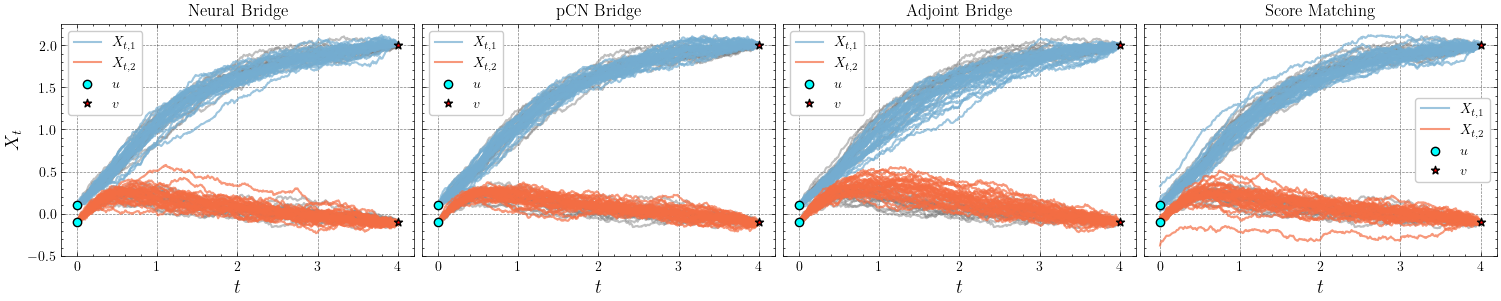

In [21]:
fig, axes = plt.subplots(1, 4, figsize=(15, 3), layout="constrained", sharey=True)

plot_sample_path(X_star_path[:16], ax=axes[0], colors=['grey', 'grey'], alpha=0.5, linewidth=1.5, zorder=1)
plot_sample_path(X_diamond_path, ax=axes[0], colors=['#74add1', '#f46d43'], label=["$X_{t,1}$", "$X_{t,2}$"], title="Neural Bridge", linewidth=1.5, zorder=2, alpha=0.7)
axes[0].scatter([0.0, 0.0], u, color="cyan", marker="o", edgecolor="black", linewidth=1.0, label=r"$u$", zorder=3)
axes[0].scatter([4.0, 4.0], v, color="red", marker="*", edgecolor="black", linewidth=1.0, label=r"$v$", zorder=3)
axes[0].set_xlabel(r"$t$", fontsize=14)
axes[0].set_ylabel(r"$X_t$", fontsize=14)
axes[0].legend()

plot_sample_path(X_star_path[:16], ax=axes[1], colors=['grey', 'grey'], alpha=0.5, linewidth=1.5, zorder=1)
plot_sample_path(X_star_pCN_path, ax=axes[1], colors=['#74add1', '#f46d43'], label=["$X_{t,1}$", "$X_{t,2}$"], title="pCN Bridge", linewidth=1.5, zorder=2, alpha=0.7)
axes[1].scatter([0.0, 0.0], u, color="cyan", marker="o", edgecolor="black", linewidth=1.0, label=r"$u$", zorder=3)
axes[1].scatter([4.0, 4.0], v, color="red", marker="*", edgecolor="black", linewidth=1.0, label=r"$v$", zorder=3)
axes[1].set_xlabel(r"$t$", fontsize=14)
axes[1].legend()

plot_sample_path(X_star_path[:16], ax=axes[2], colors=['grey', 'grey'], alpha=0.5, linewidth=1.5, zorder=1)
plot_sample_path(X_star_adjoint_path, ax=axes[2], colors=['#74add1', '#f46d43'], label=["$X_{t,1}$", "$X_{t,2}$"], title="Adjoint Bridge", linewidth=1.5, zorder=2, alpha=0.7)
axes[2].scatter([0.0, 0.0], u, color="cyan", marker="o", edgecolor="black", linewidth=1.0, label=r"$u$", zorder=3)
axes[2].scatter([4.0, 4.0], v, color="red", marker="*", edgecolor="black", linewidth=1.0, label=r"$v$", zorder=3)
axes[2].set_xlabel(r"$t$", fontsize=14)
axes[2].legend()

plot_sample_path(X_star_path[:16], ax=axes[3], colors=['grey', 'grey'], alpha=0.5, linewidth=1.5, zorder=1)
plot_sample_path(X_star_score_path, ax=axes[3], colors=['#74add1', '#f46d43'], label=["$X_{t,1}$", "$X_{t,2}$"], title="Score Matching", linewidth=1.5, zorder=2, alpha=0.7)
axes[3].scatter([0.0, 0.0], u, color="cyan", marker="o", edgecolor="black", linewidth=1.0, label=r"$u$", zorder=3)
axes[3].scatter([4.0, 4.0], v, color="red", marker="*", edgecolor="black", linewidth=1.0, label=r"$v$", zorder=3)
axes[3].set_xlabel(r"$t$", fontsize=14)
axes[3].legend()

fig.savefig("../assets/figures/cell_model/normal_events_results.pdf", dpi=300, bbox_inches="tight")
plt.show()

### Conditioning on rare events

Neural bridge

In [31]:
config = read_config("../configs/cell_rare.yaml")
print(config)
u = jnp.array(config.sde.u)
v = jnp.array(config.sde.v)

W = WienerProcess(
    T=config.sde.T,
    dt=config.sde.dt,
    shape=(config.sde.dim, )
)

X = CellDiffusionProcess(
    params=config.sde.params_X,
    T=config.sde.T,
    dim=config.sde.dim
)
X_tilde = CellDiffusionAuxProcess(
    params=config.sde.params_X_tilde,
    T=config.sde.T,
    dim=config.sde.dim
)
X_circ = GuidedBridgeProcess(
    X=X,
    X_tilde=X_tilde,
    u=u,
    v=v,
    eps=config.sde.eps,
    ts=jnp.arange(0, config.sde.T + config.sde.dt, config.sde.dt),
)
X_diamond = neurb.NeuralBridge(
    X_circ=X_circ,
    config=config
)

X_diamond.initialize_solver(W)
_ = X_diamond.train(mode="pretrained", load_relative_dir="../assets/ckpts/neurb")
X_diamond_path = X_diamond.solve(x0=u, rng_key=jax.random.PRNGKey(42), batch_size=32)

/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1136: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(
INFO:root:Checkpoint loaded from /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neurb/cell_model_rare_events_sigma0.1
INFO:root:Loading pretrained model from the last epoch


{'sde': {'dim': 2, 'T': 4.0, 'dt': 0.01, 'params_X': {'alpha': 0.0625, 'sigma': 0.1}, 'params_X_tilde': {'alpha': 0.0625, 'sigma': 0.1}, 'u': [0.1, -0.1], 'v': [1.0, -0.1], 'eps': 1e-10}, 'network': {'mlp_type': 'mlp_small', 'out_dim': 2, 'hidden_dims': [20, 20, 20, 20], 'activation': 'tanh'}, 'training': {'save_name': 'cell_model_rare_events_sigma0.1', 'learning_rate': 0.0005, 'batch_size': 64, 'n_iters': 750, 'n_epochs': 10, 'ema_decay': 0.995, 'optimizer': 'adam', 'warmup_steps': 750, 'clip_norm': None}}


Score matching

In [23]:
config = read_config("../configs/cell_rare_score.yaml")
print(config)
score_model = scorematching.ScoreMatchingReversedBridge(
    X=X,
    u=u,
    v=v,
    config=config
)
_ = score_model.train(mode="pretrained", load_relative_dir="../assets/ckpts/score/")
Y_star = score_model.build_reversed_bridge()
Y_star_solver = Euler(sde=Y_star, W=W)
Y_star_path = Y_star_solver.solve(x0=v, rng_key=jax.random.PRNGKey(42), batch_size=32)
X_star_score_path = SamplePath(
    xs=Y_star_path.xs[:, ::-1, :],
    ts=Y_star_path.ts
)

/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1136: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(
INFO:root:Checkpoint loaded from /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/score/cell_model_normal_events_sigma0.1
INFO:root:Loading pretrained model from the last epoch


{'sde': {'dim': 2, 'T': 4.0, 'dt': 0.01, 'params_X': {'alpha': 0.0625, 'sigma': 0.1}, 'u': [0.1, -0.1], 'v': [1.0, -0.1]}, 'network': {'mlp_type': 'mlp', 'out_dim': 2, 'hidden_dims': [32, 32, 32, 32], 't_emb_dim': 32, 't_emb_max_period': 100.0, 't_emb_scaling': 100.0, 'norm': 'batch', 'activation': 'tanh'}, 'training': {'save_name': 'cell_model_normal_events_sigma0.1', 'learning_rate': 0.0005, 'batch_size': 64, 'n_iters': 1000, 'n_epochs': 20, 'ema_decay': 0.995, 'optimizer': 'adam', 'warmup_steps': 1000, 'clip_norm': None}}


Adjoint forward

In [24]:
config = read_config("../configs/cell_rare_adjoint.yaml")
print(config)

network = ScoreMLP(**config.network)
ckpt = checkpoints.restore_checkpoint(
    ckpt_dir=os.path.abspath("../assets/ckpts/adjoint/cell_model_rare_0.1sigma"),
    target=None,
    step=0,
    prefix="checkpoint_"
)
params = ckpt["params"]
batch_stats = ckpt["batch_stats"]
trained_score = train_utils.trained_score(network, params, batch_stats)

cell_sde = sde_cell_model.cell_model(
    T=config.sde.T, 
    N=int(config.sde.T / config.sde.dt), 
    alpha=config.sde.alpha, 
    sigma=config.sde.sigma
)
n_samples = 32
rng_keys = jax.random.split(jax.random.PRNGKey(42), n_samples)
xs_star = jax.vmap(
    sde_utils.conditioned,
    in_axes=(0, None, None, None)
)(rng_keys, u, cell_sde, trained_score)
ts = jnp.arange(0, config.sde.T, config.sde.dt)
X_star_adjoint_path = SamplePath(
    xs=xs_star,
    ts=ts
)

{'sde': {'T': 4.0, 'dt': 0.01, 'N': 400, 'alpha': 0.0625, 'sigma': 0.1, 'u': [0.1, -0.1], 'v': [1.0, -0.1]}, 'network': {'output_dim': 2, 'time_embedding_dim': 32, 'init_embedding_dim': 16, 'activation': 'leaky_relu', 'encoder_layer_dims': [16], 'decoder_layer_dims': [128, 128]}, 'training': {'v': None, 'batch_size': 100, 'epochs_per_load': 1, 'lr': 0.01, 'num_reloads': 100, 'load_size': 100000}}


/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1136: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


Pre-conditioned Crank-Nicolson

In [29]:
config = {
    "rho": 0.98,
    "batch_size": 32,
    "n_iters": 10000
}
pCN_model = pCN.PreconditionedCrankNicolson(
    X_circ=X_circ,
    config=config
)
pCN_model.initialize_solver(W)
_, pCN_result = pCN_model.run()
X_star_pCN_path = pCN_result.path

Running for 10,000 iterations:   0%|          | 0/10000 [00:00<?, ?it/s]

INFO:root:Batch average acceptance rate: 14.57%


Brutal force sampling to obtain the "ground truth"

In [26]:
X_solver = Euler(X, W)
X_path = X_solver.solve(x0=u, rng_key=jax.random.PRNGKey(42), batch_size=100_000)
# Create masks for each component's end point conditions
x1_mask = (X_path.xs[:, -1, 0] >= v[0] - 1e-2) & (X_path.xs[:, -1, 0] <= v[0] + 1e-2)
x2_mask = (X_path.xs[:, -1, 1] >= v[1] - 1e-2) & (X_path.xs[:, -1, 1] <= v[1] + 1e-2)
final_mask = x1_mask & x2_mask
X_star_path = X_path[final_mask]
print(f"Found {X_star_path.n_samples} samples that satisfy the endpoint conditions out of {X_path.n_samples} samples")

Found 0 samples that satisfy the endpoint conditions out of 100000 samples


Plotting

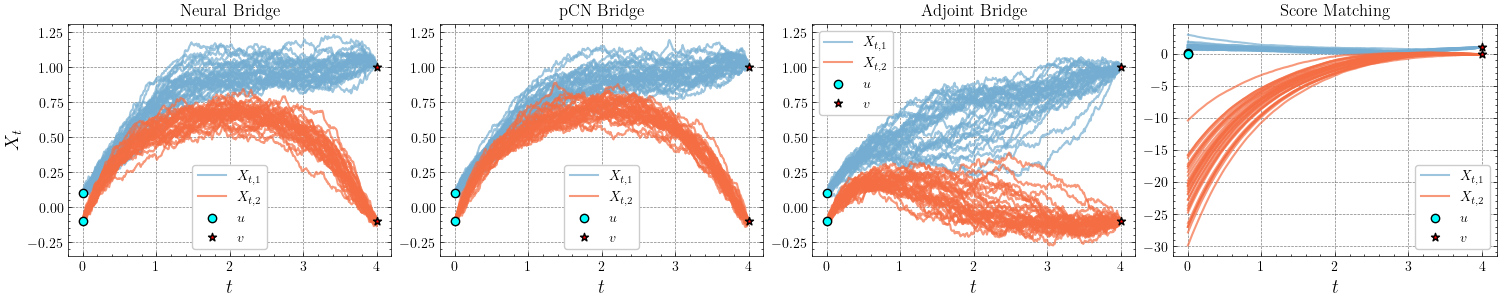

In [32]:
fig, axes = plt.subplots(1, 4, figsize=(15, 3), layout="constrained")

plot_sample_path(X_star_path[:16], ax=axes[0], colors=['grey', 'grey'], alpha=0.5, linewidth=1.5, zorder=1)
plot_sample_path(X_diamond_path, ax=axes[0], colors=['#74add1', '#f46d43'], label=["$X_{t,1}$", "$X_{t,2}$"], title="Neural Bridge", linewidth=1.5, zorder=2, alpha=0.7)
axes[0].scatter([0.0, 0.0], u, color="cyan", marker="o", edgecolor="black", linewidth=1.0, label=r"$u$", zorder=3)
axes[0].scatter([4.0, 4.0], v, color="red", marker="*", edgecolor="black", linewidth=1.0, label=r"$v$", zorder=3)
axes[0].set_xlabel(r"$t$", fontsize=14)
axes[0].set_ylabel(r"$X_t$", fontsize=14)
axes[0].legend()

plot_sample_path(X_star_path[:16], ax=axes[1], colors=['grey', 'grey'], alpha=0.5, linewidth=1.5, zorder=1)
plot_sample_path(X_star_pCN_path, ax=axes[1], colors=['#74add1', '#f46d43'], label=["$X_{t,1}$", "$X_{t,2}$"], title="pCN Bridge", linewidth=1.5, zorder=2, alpha=0.7)
axes[1].scatter([0.0, 0.0], u, color="cyan", marker="o", edgecolor="black", linewidth=1.0, label=r"$u$", zorder=3)
axes[1].scatter([4.0, 4.0], v, color="red", marker="*", edgecolor="black", linewidth=1.0, label=r"$v$", zorder=3)
axes[1].set_xlabel(r"$t$", fontsize=14)
axes[1].legend()
axes[1].sharey(axes[0])

plot_sample_path(X_star_path[:16], ax=axes[2], colors=['grey', 'grey'], alpha=0.5, linewidth=1.5, zorder=1)
plot_sample_path(X_star_adjoint_path, ax=axes[2], colors=['#74add1', '#f46d43'], label=["$X_{t,1}$", "$X_{t,2}$"], title="Adjoint Bridge", linewidth=1.5, zorder=2, alpha=0.7)
axes[2].scatter([0.0, 0.0], u, color="cyan", marker="o", edgecolor="black", linewidth=1.0, label=r"$u$", zorder=3)
axes[2].scatter([4.0, 4.0], v, color="red", marker="*", edgecolor="black", linewidth=1.0, label=r"$v$", zorder=3)
axes[2].set_xlabel(r"$t$", fontsize=14)
axes[2].legend()
axes[2].sharey(axes[0])

plot_sample_path(X_star_path[:16], ax=axes[3], colors=['grey', 'grey'], alpha=0.5, linewidth=1.5, zorder=1)
plot_sample_path(X_star_score_path, ax=axes[3], colors=['#74add1', '#f46d43'], label=["$X_{t,1}$", "$X_{t,2}$"], title="Score Matching", linewidth=1.5, zorder=2, alpha=0.7)
axes[3].scatter([0.0, 0.0], u, color="cyan", marker="o", edgecolor="black", linewidth=1.0, label=r"$u$", zorder=3)
axes[3].scatter([4.0, 4.0], v, color="red", marker="*", edgecolor="black", linewidth=1.0, label=r"$v$", zorder=3)
axes[3].set_xlabel(r"$t$", fontsize=14)
axes[3].legend()

fig.savefig("../assets/figures/cell_model/rare_events_results.pdf", dpi=300, bbox_inches="tight")
plt.show()

### Multi-modality

Neural bridge

In [41]:
config = read_config("../configs/cell_mm.yaml")
print(config)
u = jnp.array(config.sde.u)
v = jnp.array(config.sde.v)

W = WienerProcess(
    T=config.sde.T,
    dt=config.sde.dt,
    shape=(config.sde.dim, )
)

X = CellDiffusionProcess(
    params=config.sde.params_X,
    T=config.sde.T,
    dim=config.sde.dim
)
X_tilde = CellDiffusionAuxProcess(
    params=config.sde.params_X_tilde,
    T=config.sde.T,
    dim=config.sde.dim
)
X_circ = GuidedBridgeProcess(
    X=X,
    X_tilde=X_tilde,
    u=u,
    v=v,
    eps=config.sde.eps,
    ts=jnp.arange(0, config.sde.T + config.sde.dt, config.sde.dt),
)
X_diamond = neurb.NeuralBridge(
    X_circ=X_circ,
    config=config
)

X_diamond.initialize_solver(W)
_ = X_diamond.train(mode="pretrained", load_relative_dir="../assets/ckpts/neurb")
X_diamond_path = X_diamond.solve(x0=u, rng_key=jax.random.PRNGKey(42), batch_size=32)

/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1136: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(
INFO:root:Checkpoint loaded from /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neurb/cell_model_mm_sigma0.1
INFO:root:Loading pretrained model from the last epoch


{'sde': {'dim': 2, 'T': 5.0, 'dt': 0.01, 'params_X': {'alpha': 0.0625, 'sigma': 0.1}, 'params_X_tilde': {'alpha': 0.0625, 'sigma': 0.1}, 'u': [-1.0, -1.0], 'v': [-1.0, -1.0], 'eps': 1e-10}, 'network': {'mlp_type': 'mlp_small', 'out_dim': 2, 'hidden_dims': [20, 20, 20, 20], 'activation': 'tanh'}, 'training': {'save_name': 'cell_model_mm_sigma0.1', 'learning_rate': 0.0005, 'batch_size': 64, 'n_iters': 500, 'n_epochs': 10, 'ema_decay': 0.995, 'optimizer': 'adam', 'warmup_steps': 500, 'clip_norm': None}}


score matching

In [34]:
config = read_config("../configs/cell_mm_score.yaml")
print(config)
score_model = scorematching.ScoreMatchingReversedBridge(
    X=X,
    u=u,
    v=v,
    config=config
)
_ = score_model.train(mode="pretrained", load_relative_dir="../assets/ckpts/score/")
Y_star = score_model.build_reversed_bridge()
Y_star_solver = Euler(sde=Y_star, W=W)
Y_star_path = Y_star_solver.solve(x0=v, rng_key=jax.random.PRNGKey(42), batch_size=32)
X_star_score_path = SamplePath(
    xs=Y_star_path.xs[:, ::-1, :],
    ts=Y_star_path.ts
)

/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1136: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(
INFO:root:Checkpoint loaded from /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/score/cell_model_mm_sigma0.1
INFO:root:Loading pretrained model from the last epoch


{'sde': {'dim': 2, 'T': 5.0, 'dt': 0.01, 'params_X': {'alpha': 0.0625, 'sigma': 0.1}, 'u': [-1.0, -1.0], 'v': [-1.0, -1.0]}, 'network': {'mlp_type': 'mlp', 'out_dim': 2, 'hidden_dims': [32, 32, 32, 32], 't_emb_dim': 32, 't_emb_max_period': 100.0, 't_emb_scaling': 100.0, 'norm': 'batch', 'activation': 'tanh'}, 'training': {'save_name': 'cell_model_mm_sigma0.1', 'learning_rate': 0.0005, 'batch_size': 64, 'n_iters': 1000, 'n_epochs': 20, 'ema_decay': 0.995, 'optimizer': 'adam', 'warmup_steps': 1000, 'clip_norm': None}}


Adjoint forward

In [36]:
config = read_config("../configs/cell_mm_adjoint.yaml")
print(config)

from flax.training import checkpoints
from legacies.adjoint_forward.models.score_mlp import ScoreMLP
from legacies.adjoint_forward.sdes import sde_cell_model, sde_utils
from legacies.adjoint_forward.training import train_utils
network = ScoreMLP(**config.network)
ckpt = checkpoints.restore_checkpoint(
    ckpt_dir=os.path.abspath("../assets/ckpts/adjoint/cell_model_mm_0.1sigma"),
    target=None,
    step=0,
    prefix="checkpoint_"
)
params = ckpt["params"]
batch_stats = ckpt["batch_stats"]
trained_score = train_utils.trained_score(network, params, batch_stats)

cell_sde = sde_cell_model.cell_model(
    T=config.sde.T, 
    N=int(config.sde.T / config.sde.dt), 
    alpha=config.sde.alpha, 
    sigma=config.sde.sigma
)
n_samples = 32
rng_keys = jax.random.split(jax.random.PRNGKey(42), n_samples)
xs_star = jax.vmap(
    sde_utils.conditioned,
    in_axes=(0, None, None, None)
)(rng_keys, u, cell_sde, trained_score)
ts = jnp.arange(0, config.sde.T, config.sde.dt)
X_star_adjoint_path = SamplePath(
    xs=xs_star,
    ts=ts
)

{'sde': {'T': 5.0, 'dt': 0.01, 'N': 400, 'alpha': 0.0625, 'sigma': 0.1, 'u': [-1.0, -1.0], 'v': [-1.0, -1.0]}, 'network': {'output_dim': 2, 'time_embedding_dim': 32, 'init_embedding_dim': 16, 'activation': 'leaky_relu', 'encoder_layer_dims': [16], 'decoder_layer_dims': [128, 128]}, 'training': {'v': None, 'batch_size': 100, 'epochs_per_load': 1, 'lr': 0.01, 'num_reloads': 100, 'load_size': 100000}}


/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1136: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


Pre-conditioned Crank-Nicolson

In [42]:
config = {
    "rho": 0.9,
    "batch_size": 32,
    "n_iters": 10000
}
pCN_model = pCN.PreconditionedCrankNicolson(
    X_circ=X_circ,
    config=config
)
pCN_model.initialize_solver(W)
_, pCN_result = pCN_model.run()
X_star_pCN_path = pCN_result.path

Running for 10,000 iterations:   0%|          | 0/10000 [00:00<?, ?it/s]

INFO:root:Batch average acceptance rate: 25.64%


Brutal force sampling to obtain the "ground truth"

In [43]:
X_solver = Euler(X, W)
X_path = X_solver.solve(x0=u, rng_key=jax.random.PRNGKey(42), batch_size=100_000)
# Create masks for each component's end point conditions
x1_mask = (X_path.xs[:, -1, 0] >= v[0] - 1e-2) & (X_path.xs[:, -1, 0] <= v[0] + 1e-2)
x2_mask = (X_path.xs[:, -1, 1] >= v[1] - 1e-2) & (X_path.xs[:, -1, 1] <= v[1] + 1e-2)
final_mask = x1_mask & x2_mask
X_star_path = X_path[final_mask]
print(f"Found {X_star_path.n_samples} samples that satisfy the endpoint conditions out of {X_path.n_samples} samples")

Found 0 samples that satisfy the endpoint conditions out of 100000 samples


Plotting

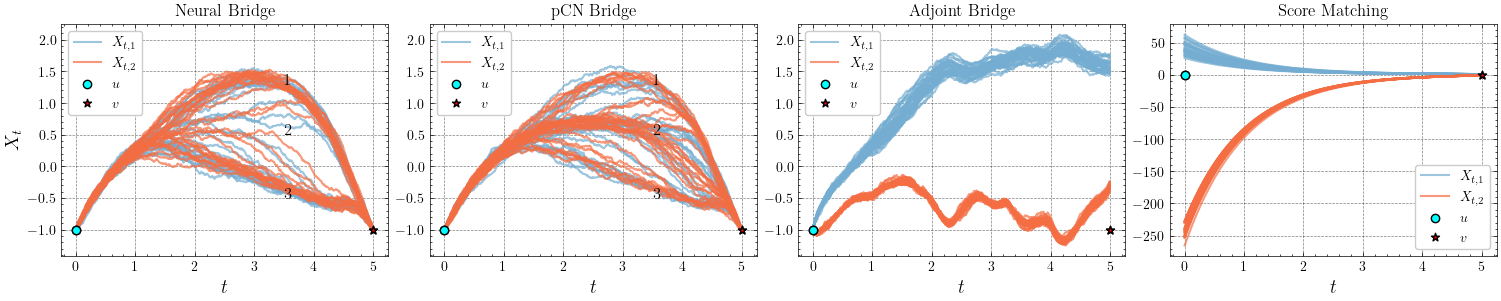

In [95]:
fig, axes = plt.subplots(1, 4, figsize=(15, 3), layout="constrained")

plot_sample_path(X_star_path[:16], ax=axes[0], colors=['grey', 'grey'], alpha=0.5, linewidth=1.5, zorder=1)
plot_sample_path(X_diamond_path, ax=axes[0], colors=['#74add1', '#f46d43'], label=["$X_{t,1}$", "$X_{t,2}$"], title="Neural Bridge", linewidth=1.5, zorder=2, alpha=0.7)
axes[0].scatter([0.0, 0.0], u, color="cyan", marker="o", edgecolor="black", linewidth=1.0, label=r"$u$", zorder=3)
axes[0].scatter([5.0, 5.0], v, color="red", marker="*", edgecolor="black", linewidth=1.0, label=r"$v$", zorder=3)
axes[0].set_xlabel(r"$t$", fontsize=14)
axes[0].set_ylabel(r"$X_t$", fontsize=14)
axes[0].text(3.5, 1.3, "1", color="black", fontsize=12, fontweight="bold")
axes[0].text(3.5, 0.5, "2", color="black", fontsize=12, fontweight="bold")
axes[0].text(3.5, -0.5, "3", color="black", fontsize=12, fontweight="bold")
axes[0].legend()

plot_sample_path(X_star_path[:16], ax=axes[1], colors=['grey', 'grey'], alpha=0.5, linewidth=1.5, zorder=1)
plot_sample_path(X_star_pCN_path, ax=axes[1], colors=['#74add1', '#f46d43'], label=["$X_{t,1}$", "$X_{t,2}$"], title="pCN Bridge", linewidth=1.5, zorder=2, alpha=0.7)
axes[1].scatter([0.0, 0.0], u, color="cyan", marker="o", edgecolor="black", linewidth=1.0, label=r"$u$", zorder=3)
axes[1].scatter([5.0, 5.0], v, color="red", marker="*", edgecolor="black", linewidth=1.0, label=r"$v$", zorder=3)
axes[1].set_xlabel(r"$t$", fontsize=14)
axes[1].text(3.5, 1.3, "1", color="black", fontsize=12, fontweight="bold")
axes[1].text(3.5, 0.5, "2", color="black", fontsize=12, fontweight="bold")
axes[1].text(3.5, -0.5, "3", color="black", fontsize=12, fontweight="bold")
axes[1].legend()
axes[1].sharey(axes[0])

plot_sample_path(X_star_path[:16], ax=axes[2], colors=['grey', 'grey'], alpha=0.5, linewidth=1.5, zorder=1)
plot_sample_path(X_star_adjoint_path, ax=axes[2], colors=['#74add1', '#f46d43'], label=["$X_{t,1}$", "$X_{t,2}$"], title="Adjoint Bridge", linewidth=1.5, zorder=2, alpha=0.7)
axes[2].scatter([0.0, 0.0], u, color="cyan", marker="o", edgecolor="black", linewidth=1.0, label=r"$u$", zorder=3)
axes[2].scatter([5.0, 5.0], v, color="red", marker="*", edgecolor="black", linewidth=1.0, label=r"$v$", zorder=3)
axes[2].set_xlabel(r"$t$", fontsize=14)
axes[2].legend()
axes[2].sharey(axes[0])

plot_sample_path(X_star_path[:16], ax=axes[3], colors=['grey', 'grey'], alpha=0.5, linewidth=1.5, zorder=1)
plot_sample_path(X_star_score_path, ax=axes[3], colors=['#74add1', '#f46d43'], label=["$X_{t,1}$", "$X_{t,2}$"], title="Score Matching", linewidth=1.5, zorder=2, alpha=0.7)
axes[3].scatter([0.0, 0.0], u, color="cyan", marker="o", edgecolor="black", linewidth=1.0, label=r"$u$", zorder=3)
axes[3].scatter([5.0, 5.0], v, color="red", marker="*", edgecolor="black", linewidth=1.0, label=r"$v$", zorder=3)
axes[3].set_xlabel(r"$t$", fontsize=14)
axes[3].legend()

fig.savefig("../assets/figures/cell_model/multimodality_results.pdf", dpi=300, bbox_inches="tight")
plt.show()

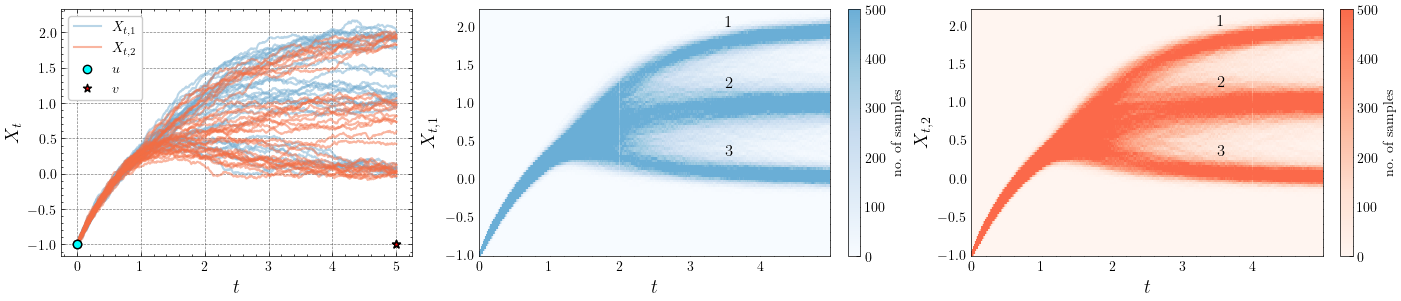

In [73]:
fig, axes = plt.subplots(1, 3, figsize=(14, 3), layout="constrained")

plot_sample_path(X_path[:32], ax=axes[0], colors=['#74add1', '#f46d43'], label=["$X_{t,1}$", "$X_{t,2}$"], alpha=0.5, linewidth=1.5, zorder=1)
axes[0].scatter([0.0, 0.0], u, color="cyan", marker="o", edgecolor="black", linewidth=1.0, label=r"$u$", zorder=3)
axes[0].scatter([5.0, 5.0], v, color="red", marker="*", edgecolor="black", linewidth=1.0, label=r"$v$", zorder=3)
axes[0].set_xlabel(r"$t$", fontsize=14)
axes[0].set_ylabel(r"$X_t$", fontsize=14)
axes[0].legend()

from neuralbridge.utils.plotting import plot_sample_path_histogram

# Create truncated colormaps that don't go all the way to the most intense colors
blues_cmap = plt.get_cmap('Blues')
oranges_cmap = plt.get_cmap('Reds')
truncated_blues = plt.matplotlib.colors.LinearSegmentedColormap.from_list(
    'trunc_blues', blues_cmap(jnp.linspace(0, 0.5, 256)))
truncated_oranges = plt.matplotlib.colors.LinearSegmentedColormap.from_list(
    'trunc_oranges', oranges_cmap(jnp.linspace(0, 0.5, 256)))


plot_sample_path_histogram(X_path[:5000], plot_dim=0, ax=axes[1], cmap=truncated_blues, norm="linear")
axes[1].text(3.5, 2.0, "1", color="black", fontsize=12)
axes[1].text(3.5, 1.2, "2", color="black", fontsize=12)
axes[1].text(3.5, 0.3, "3", color="black", fontsize=12)
axes[1].set_ylabel(r"$X_{t,1}$", fontsize=14)
axes[1].set_xlabel(r"$t$", fontsize=14)


plot_sample_path_histogram(X_path[:5000], plot_dim=1, ax=axes[2], cmap=truncated_oranges, norm="linear")
axes[2].text(3.5, 2.0, "1", color="black", fontsize=12)
axes[2].text(3.5, 1.2, "2", color="black", fontsize=12)
axes[2].text(3.5, 0.3, "3", color="black", fontsize=12)
axes[2].set_ylabel(r"$X_{t,2}$", fontsize=14)
axes[2].set_xlabel(r"$t$", fontsize=14)

fig.savefig("../assets/figures/cell_model/multimodality_unconditional_histogram.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [77]:
config = {
    "rho": 0.9,
    "batch_size": 1,
    "n_iters": 10000
}
pCN_model = pCN.PreconditionedCrankNicolson(
    X_circ=X_circ,
    config=config
)
pCN_model.initialize_solver(W)
pCN_logs, _ = pCN_model.run(log_every=100)

Running pCN with log every 100:   0%|          | 0/10000 [00:00<?, ?it/s]

INFO:root:Batch average acceptance rate: 22.49%


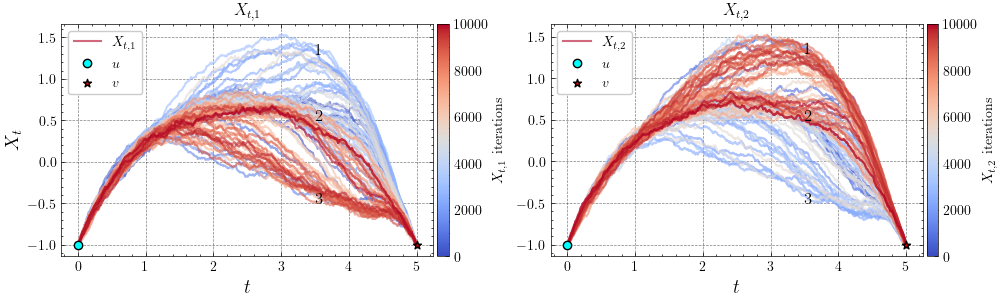

In [96]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3), layout="constrained")
plot_mcmc_sample_path(
    pCN_logs,
    plot_dims=0,
    ax=axes[0],
    label=r"$X_{t,1}$",
    title=r"$X_{t,1}$",
    cmaps="coolwarm",
    alpha=0.6,
    linewidth=1.5,
    n_iters=10000
)
axes[0].set_xlabel(r"$t$", fontsize=14)
axes[0].set_ylabel(r"$X_t$", fontsize=14)
axes[0].scatter([0.0], u[0], color="cyan", marker="o", edgecolor="black", linewidth=1.0, label=r"$u$", zorder=3)
axes[0].scatter([5.0], v[0], color="red", marker="*", edgecolor="black", linewidth=1.0, label=r"$v$", zorder=3)
axes[0].text(3.5, 1.3, "1", color="black", fontsize=12, fontweight="bold")
axes[0].text(3.5, 0.5, "2", color="black", fontsize=12, fontweight="bold")
axes[0].text(3.5, -0.5, "3", color="black", fontsize=12, fontweight="bold")
axes[0].legend()

plot_mcmc_sample_path(
    pCN_logs,
    plot_dims=1,
    ax=axes[1],
    label=r"$X_{t,2}$",
    title=r"$X_{t,2}$",
    cmaps="coolwarm",
    alpha=0.6,
    linewidth=1.5,
    n_iters=10000
)
axes[1].set_xlabel(r"$t$", fontsize=14)
axes[1].scatter([0.0], u[1], color="cyan", marker="o", edgecolor="black", linewidth=1.0, label=r"$u$", zorder=3)
axes[1].scatter([5.0], v[1], color="red", marker="*", edgecolor="black", linewidth=1.0, label=r"$v$", zorder=3)
axes[1].text(3.5, 1.3, "1", color="black", fontsize=12, fontweight="bold")
axes[1].text(3.5, 0.5, "2", color="black", fontsize=12, fontweight="bold")
axes[1].text(3.5, -0.5, "3", color="black", fontsize=12, fontweight="bold")
axes[1].legend()

fig.savefig("../assets/figures/cell_model/multimodality_mcmc_logs.pdf", dpi=300, bbox_inches="tight")
plt.show()